### Automated Analysis on SPADE tree using Chat GPT

Pseudocode ->
1. for cluser in n_cluster:
    2. add binary outcome (in or not in cluster) for each event
    3. Run random forest ML classifier, extract features
    4. run SHAP and get negative/positive corr of extracted features
    5. ask for annotation in Chat GPT -> save label
6. add label attributes to nodes in tree
7. visualise annotation


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
from ipywidgets import FloatProgress
import shap
import xgboost as xgb
import pandas as pd
import random
import lightgbm as lgb

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
og_data = pd.read_csv('GPT_df.csv', index_col=0)

In [3]:
markers_list = ['c-kit', 'Sca-1', 'CD150', 'CD11b', 'B220', 'TCRB', 'CD4', 'CD8']

In [22]:
outcome = np.zeros((og_data.shape[0],1))
outcome[np.where(og_data['cluster_id']==1)] = 1
og_data['cluster_outcome']  = outcome

 

In [23]:
in_cluster = np.array(random.choices(np.where(og_data['cluster_id']==1)[0],k=1000))
out_cluster = np.array(random.choices(np.where(og_data['cluster_id']==0)[0],k=1000))
ind = np.array([*in_cluster,*out_cluster])
gpt_data = og_data.iloc[ind]
X_train = gpt_data[markers_list].to_numpy()
y_train = gpt_data['cluster_outcome']
X_train.shape

(2000, 8)

In [16]:
og_data[og_data['cluster_id']==10]

,c-kit,Sca-1,CD150,CD11b,B220,TCRB,CD4,CD8,id_nearest,cluster_id,cluster_outcome
246,0.170840,0.058342,0.324079,0.063562,0.419363,0.435346,0.477362,0.275370,4336,10,1.0
285,0.431730,0.047524,0.337411,0.096680,0.169587,0.426953,0.434441,0.159680,11057,10,1.0
302,0.446049,0.176925,0.392701,0.019766,0.059475,0.131753,0.399097,0.405762,91,10,1.0
328,0.505898,0.046471,0.094673,0.012622,0.054359,0.441575,0.178113,0.378276,96,10,1.0
370,0.505169,0.144324,0.410098,0.103517,0.104140,0.473182,0.492120,0.061145,107,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...
49776,0.430169,0.125445,0.288438,0.183163,0.121120,0.462627,0.140920,0.409901,13453,10,1.0
49827,0.534458,0.056336,0.422924,0.102143,0.181072,0.377846,0.531782,0.446964,13469,10,1.0
49855,0.478745,0.066469,0.120834,0.019083,0.073650,0.136745,0.483308,0.473290,11201,10,1.0
49902,0.223255,0.168474,0.530914,0.029763,0.070948,0.525431,0.513261,0.173568,611,10,1.0


In [7]:
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_train, y_train)   

explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

#shap.plots.waterfall(shap_values[0])

Exact explainer: 2001it [00:12, 33.83it/s]                           


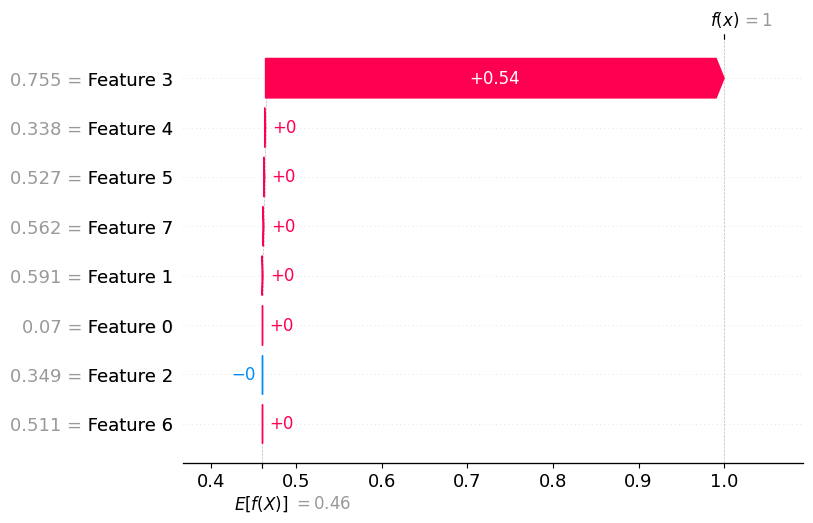

In [26]:
shap.plots.waterfall(shap_values[0])

In [25]:
shap_values


.values =
array([[ 3.46944695e-17,  1.00000000e-03, -1.56125113e-17, ...,
         1.00000000e-03,  8.67361738e-18,  1.00000000e-03],
       [-7.14285714e-05,  9.28571429e-04,  9.52380952e-05, ...,
         9.28571429e-04,  8.33333333e-04,  1.09523810e-03],
       [ 3.57142857e-05,  8.69047619e-04,  3.57142857e-05, ...,
         8.69047619e-04,  7.73809524e-04,  1.10714286e-03],
       ...,
       [ 3.05952381e-03, -2.29642857e-02, -2.82142857e-03, ...,
        -2.85833333e-02, -5.99880952e-02, -7.05952381e-03],
       [-3.57142857e-05, -3.57142857e-05, -3.69047619e-04, ...,
        -2.79761905e-03, -2.79761905e-03, -3.69047619e-04],
       [ 2.08166817e-17, -1.66666667e-04, -6.66666667e-04, ...,
        -3.66666667e-03, -6.66666667e-04,  0.00000000e+00]])

.base_values =
array([0.46, 0.46, 0.46, ..., 0.46, 0.46, 0.46])

.data =
array([[0.07046971, 0.59114541, 0.34892743, ..., 0.5267247 , 0.51104863,
        0.56185236],
       [0.04361372, 0.55371472, 0.53397481, ..., 0.53484668, 0.61

In [7]:
gpt_prompt = np.empty((shap_values[0].values.shape[0],1))

In [10]:
gpt_prompt = np.empty((shap_values[0].values.shape[0],1)).astype(str)
for i in range(shap_values[0].values.shape[0]):
    val = shap_values[0].values[i]
    if abs(val) >0.0099:
        if val < 0:
            gpt_prompt[i] = 'low'
        else:
            gpt_prompt[i] = 'high'
    else:
        gpt_prompt[i] = 'na'

gpt_cp = np.column_stack((gpt_prompt,markers_list))
print(gpt_cp)
gpt_final_prompt = gpt_cp[np.where(gpt_cp[:,0]!='na')]
cluster_gpt = ','.join([' '.join(row) for row in gpt_final_prompt])
print(cluster_gpt)

[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['high' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]
high CD11b


In [5]:
def get_shap_val(data, markers_list, cluster_num, in_cluster_sample = 1000, out_cluster_sample = 1000, model = 'xgb'):
    outcome = np.zeros((data.shape[0],1))
    outcome[np.where(data['cluster_id']==cluster_num)] = 1
    data['cluster_outcome']  = outcome
    in_cluster = np.array(random.choices(np.where(data['cluster_id']==1)[0],k=in_cluster_sample))
    out_cluster = np.array(random.choices(np.where(data['cluster_id']==0)[0],k=out_cluster_sample))
    ind = np.array([*in_cluster,*out_cluster])
    #ind[np.where(ind >= 50000)]
    gpt_data = data.iloc[ind]
    X_train = gpt_data[markers_list].to_numpy()
    y_train = gpt_data['cluster_outcome']
    if model == 'xgb':
        model = xgb.XGBClassifier(objective="binary:logistic")
        model.fit(X_train, y_train)   
    elif model=='lgbm':
        model = lgb.LGBMClassifier()
        model.fit(X_train, y_train)
    explainer = shap.Explainer(model.predict, X_train)
    shap_values = explainer(X_train)
    print(shap_values.values)
    gpt_prompt = np.empty((shap_values[0].values.shape[0],1)).astype(str)

    for i in range(shap_values[0].values.shape[0]):
        val = shap_values[0].values[i]
        if abs(val) >0.0099:
            if val < 0:
                gpt_prompt[i] = 'low'
            else:
                gpt_prompt[i] = 'high'
        else:
            gpt_prompt[i] = 'na'

    gpt_cp = np.column_stack((gpt_prompt,markers_list))
    print(gpt_cp)
    gpt_final_prompt = gpt_cp[np.where(gpt_cp[:,0]!='na')]
    cluster_gpt = ','.join([' '.join(row) for row in gpt_final_prompt])
    return cluster_gpt


In [8]:
cluster_num = 50
prompt_dict = { }
for x in range(cluster_num):
    prop_clus = get_shap_val(og_data, markers_list, x, model='xgb')
    print(prop_clus)
    prompt_dict[x] = prop_clus

Exact explainer: 2001it [00:13, 42.59it/s]                           


[[-4.16333634e-17 -1.56125113e-17 -1.56125113e-17 ...  1.73472348e-18
   0.00000000e+00  0.00000000e+00]
 [-4.16333634e-17 -1.56125113e-17 -1.56125113e-17 ...  1.73472348e-18
   0.00000000e+00  0.00000000e+00]
 [-4.16333634e-17 -1.56125113e-17 -1.56125113e-17 ...  1.73472348e-18
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.38777878e-17 -2.94902991e-17  2.60208521e-17 ...  1.73472348e-18
   8.67361738e-18  0.00000000e+00]
 [-1.38777878e-17 -2.94902991e-17  2.60208521e-17 ...  1.73472348e-18
   8.67361738e-18  0.00000000e+00]
 [-1.38777878e-17 -2.94902991e-17  2.60208521e-17 ...  1.73472348e-18
   8.67361738e-18  0.00000000e+00]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['low' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]
low CD11b


Exact explainer: 2001it [00:11, 17.81it/s]                           


[[-4.85722573e-17  5.00000000e-04 -1.21430643e-17 ...  5.00000000e-04
   5.00000000e-04  0.00000000e+00]
 [-6.93889390e-18  3.33333333e-04 -1.73472348e-18 ...  2.00000000e-03
   1.16666667e-03  0.00000000e+00]
 [ 6.24500451e-17  6.66666667e-04  6.66666667e-04 ...  1.50000000e-03
   8.67361738e-18  0.00000000e+00]
 ...
 [ 6.93889390e-18  1.56125113e-17  8.67361738e-18 ...  8.67361738e-18
   8.67361738e-18  0.00000000e+00]
 [ 6.93889390e-18  1.56125113e-17  8.67361738e-18 ...  8.67361738e-18
   8.67361738e-18  0.00000000e+00]
 [ 6.93889390e-18  1.56125113e-17  8.67361738e-18 ...  8.67361738e-18
   8.67361738e-18  0.00000000e+00]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['high' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]
high CD11b


Exact explainer: 2001it [00:10,  7.41it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  6.37it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['n

Exact explainer: 2001it [00:10,  1.98it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.78it/s]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.43s/it]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.67s/it]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  2.56it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.59it/s]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['n

Exact explainer: 2001it [00:10,  3.34s/it]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  2.85it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.59it/s]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  4.59it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  4.87it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  3.73it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.29it/s]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  3.53it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  2.50s/it]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  3.44it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  5.91it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10, 11.86it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.68it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  7.50it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:12, 32.95it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.69it/s]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.29it/s]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  4.88it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10, 15.47it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.43s/it]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:12, 29.35it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  6.11it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



Exact explainer: 2001it [00:10,  1.43s/it]                  


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['n

Exact explainer: 2001it [00:10,  4.96it/s]                           


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['na' 'c-kit']
 ['na' 'Sca-1']
 ['na' 'CD150']
 ['na' 'CD11b']
 ['na' 'B220']
 ['na' 'TCRB']
 ['na' 'CD4']
 ['na' 'CD8']]



In [10]:
init_prompt = "Identify cell types of human pbmc using the following protein concentrations. Identify one cell type for each row. Only provide the cell type name."
for x in prompt_dict:
    init_prompt += "\n" + prompt_dict[x]

In [11]:
init_prompt

'Identify cell types of human pbmc using the following protein concentrations. Identify one cell type for each row. Only provide the cell type name.\nlow CD11b\nhigh CD11b\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [9]:
prompt_dict

{0: 'low CD11b',
 1: 'high CD11b',
 2: '',
 3: '',
 4: '',
 5: '',
 6: '',
 7: '',
 8: '',
 9: '',
 10: '',
 11: '',
 12: '',
 13: '',
 14: '',
 15: '',
 16: '',
 17: '',
 18: '',
 19: '',
 20: '',
 21: '',
 22: '',
 23: '',
 24: '',
 25: '',
 26: '',
 27: '',
 28: '',
 29: '',
 30: '',
 31: '',
 32: '',
 33: '',
 34: '',
 35: '',
 36: '',
 37: '',
 38: '',
 39: '',
 40: '',
 41: '',
 42: '',
 43: '',
 44: '',
 45: '',
 46: '',
 47: '',
 48: '',
 49: ''}